# EXERCISE 5 - ML - Grundverfahren
We start by loading our Regression data set.

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')
x_plot = np.load('x_plot.npy')
y_plot = np.load('y_plot.npy')

# the data noise is 1
sigma_y = 1

## 1.) Bayesian Linear Regression (10 Points)
We will start the exercise with Bayesian Linear Regression. First we define some hyperparameters which we fix and do not change

In [10]:
# hyperparameters
n_features = 5    # number of radial basis functions we want to use
lamb = 1e-3       # lambda regularization parameter
# the means of the Radial basis functions
features_means = np.linspace(np.min(x_plot), np.max(x_plot), n_features)   

### Exercise 1.1) Radial Basis Function Features (5 Points)
Remember from lecture 7 the radial basis function feature
\begin{align*}
\phi_i(\boldsymbol{x})=\exp\left(-\dfrac{||\boldsymbol{x}-\boldsymbol{\mu}_i||^2}{2\sigma^2}\right),
\end{align*}
for the i. feature with mean $\boldsymbol{\mu}_i$ and variance $\sigma^2$. We will assume to have the same variance for each feature function in the following.<br>
We will normalize the features in order to avoid difficulties caused by numerical issues. 
For that purpose, make sure that you divide the feature vector $\boldsymbol{\phi}(\boldsymbol{x})$ by the sum over all Radial Basis features for each input $\boldsymbol{x}$. Take out the bias from the normalization. Thus, add the bias to the end of your feature vector <b>after</b> the normalization.<br>
Your normalized feature matrix should have the form
\begin{align*}
\boldsymbol{\Phi}=
    \left(
    \begin{array}{cccc}
    \tilde{\phi}_1(\boldsymbol{x}_1) & \tilde{\phi}_2(\boldsymbol{x}_1) &...& \tilde{\phi}_k(\boldsymbol{x}_1) &1\\
    \vdots &\vdots &\vdots &\vdots &\vdots\\
    \tilde{\phi}_1(\boldsymbol{x}_N) & \tilde{\phi}_2(\boldsymbol{x}_N) &...& \tilde{\phi}_k(\boldsymbol{x}_N) & 1\\
    \end{array}
    \right),
\end{align*}
where the ith row of $\boldsymbol{\Phi}$ corresponds to the normalized feature vector $\boldsymbol{\phi}_i(\boldsymbol{x})$ concatenated with the bias 1. <br>
<b>Note:</b> The normalization of eacht row in $\boldsymbol{\Phi}$ (except for the bias) has to be calculated for each input $\boldsymbol{x}$ independantly. The normalization constant for ith row is therefore $z_i =\sum_l^k \phi_l(\boldsymbol{x}_i)$, where k is the number of features.<br><br>
Implement the following function, which should return the <b>normalized</b> feature matrix stated as before.

In [11]:
def rbf(x, mean, sigma) -> float:
    return np.exp(-(np.linalg.norm(x-mean,axis=-1)**2)/(2*(sigma**2)))

def rbf_features(x: np.ndarray, means: np.ndarray, sigma:float) -> np.ndarray:
    """
    :param x: input parameter (shape: [N, d])
    :param means: means of each rbf function (shape: [k, d] (k=num features))
    :param sigma: bandwidth parameter. We use the same for all rbfs here
    :return : returns the radial basis features including the bias value 1 (shape: [N, k+1])
    """
    if len(x.shape) == 1:
        x = x.reshape((-1, 1))

    if len(means.shape) == 1:
        means = means.reshape((-1, 1))
    ############################################################
    # TODO Implement the normalized rbf features
    features: np.ndarray = np.ones((x.shape[0], means.shape[0] + 1))    #[N, k+1]
    N,k = x.shape[0], means.shape[0]
    
    for index, mean in enumerate(means):
        features[:,index] = rbf(x, mean, sigma)
    
    # normalize by dividing each value by the overall sum
    features[:,0:k] /= np.sum(features[:, 0:k])    
    
    ############################################################
    return features

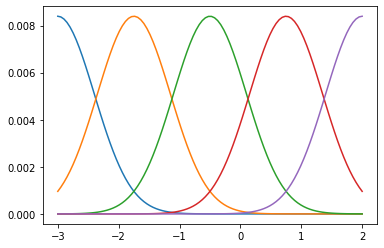

In [12]:
feat_plot = plt.figure("Features")
feat_sigma = 0.6
y_featuers = rbf_features(x_plot, features_means, sigma=feat_sigma)
plt.plot(x_plot, y_featuers[:, :-1])

### Exercise 1.2) Posterior Distribution (2 Points)

In this exercise we will implement the posterior distribution of the parameters for Bayesian Linear Regression as stated in the slides. We will directly make use of the closed-form solutions for the posterior mean and the posterior covariance as stated in the slides. <br>
By using the Radial Basis function features (see exercise 1.1)), implement the following function, which should return you the posterior mean and the posterior covariance given the inputs to the function.<br> <br> 
<b>Note:</b>The data standard deviation $\sigma_y$ which you also need to implement the equations is fixed to 1 already at the beginning of the notebook and is defined as a global variable. The function therefore does not need $\sigma_y$ as an argument. You can simply make use of it.

In [17]:
def posterior_distr(X: np.ndarray, y: np.ndarray, lamb:float, means: np.ndarray, sigma_feat:float):
    """
    :param x: input training data (shape: [N, d])
    :param y: output training data (shape: [N, 1])
    :param lamb: regularization factor (scalar)
    :param means: means of each rbf feature (shape: [k, d])
    :param sigma_feat: bandwidth of the features (scalar)
    :return : returns the posterior mean (shape: [k+1, 1])
                      the posterior covariance (shape: [k+1, k+1]) 
    """
    if len(y.shape) == 1:
        y = y.reshape((-1, 1))
    ############################################################
    # TODO Implement the posterior distribution
    k = means.shape[0]
    Phi = rbf_features(X, means, sigma_feat)
    post_mean = np.linalg.inv(Phi.T @ Phi + (sigma_y**2) * lamb * np.eye(k+1)) @ Phi.T @ y
    post_cov = (sigma_y**2) * np.linalg.inv(Phi.T @ Phi + (sigma_y**2) * lamb * np.eye(k+1))
    ############################################################
    return post_mean, post_cov

### Exercise 1.3) Predictive Distribution (3Points)
In this exercise we will implement the predictive distribution for Bayesian Linear Regression as stated in the slides. We will directly make use of the closed-form solutions for the mean and the variance as stated in the slides. <br>
By using the Radial Basis function features (see exercise 1.1)), implement the following function, which should return you the mean and the covariance given the inputs to the function.<br> <br> 
<b>Note:</b>The data standard deviation $\sigma_y$ which you also need to implement the equations is fixed to 1 already at the beginning of the notebook and is defined as a global variable. The function therefore does not need $\sigma_y$ as an argument. You can simply make use of it.

In [18]:
def predictive_distr(x: np.ndarray, y: np.ndarray, X: np.ndarray, lamb:float, means: np.ndarray, sigma_feat:float):
    """"
    :param x: input data (shape: [N, d])
    :param y: output training data (shape: [N, 1])
    :param X: input training data (shape: [N, d])
    :param means: means of each rbf feature (shape: [k, d])
    :param sigma_feat: bandwidth of the features (scalar)
    :return : returns the mean (shape: [N, d])
                      the variance (shape: [N])
                      of the predictive distribution
    """
    ############################################################
    # TODO Implement the predictive distribution
    
    Phi = rbf_features(X, means, sigma_feat)
    # post_mean, _ = posterior_distr(X,y, lamb, means, sigma_feat) # we could reuse, maybe?
    k = means.shape[0]
    phi_x = rbf_features(x, means, sigma_feat)
    mean_x = phi_x.dot(np.linalg.inv(Phi.T @ Phi + (sigma_y**2) * lamb * np.eye(k+1)) @ Phi.T @ y)
    var_x = (sigma_y**2) * (1 + phi_x @ np.linalg.inv(Phi.T @ Phi + (sigma_y**2) * lamb * np.eye(k+1)) @ phi_x.T)
    var_x = np.sum(var_x, axis=1) # this is a 100% wrong
    ############################################################
    return mean_x, var_x

This function is used to perform predictions for weights sampled from the posterior. You don't need to implement anything here.

In [19]:
def pred_lin_regr( weights: np.ndarray, input_features: np.ndarray):
    """
    :param x: input data (shape: [N, d])
    :param weights: weights for linear regression (shape: [k+1, 1])
    :param input_features: applied features on data to predict on (shape: [N, k+1])
    :return : returns the predictions to the inputs
    """
    return input_features @ weights

Perform predictions

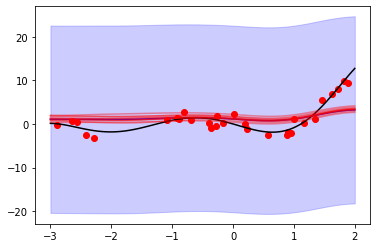

In [20]:
# first get the predictive distribution
pred_mean, pred_var = predictive_distr(x_plot, y_train, x_train, lamb=lamb, 
                                       means=features_means, sigma_feat=feat_sigma)

# plot the predictive distribution together with the 95%intervall
plt.figure('Predictve Distr')
plt.plot(x_plot, pred_mean, 'b')
plt.fill_between(np.squeeze(x_plot), np.squeeze(pred_mean)-2*np.sqrt(pred_var), 
                 np.squeeze(pred_mean)+2*np.sqrt(pred_var), alpha=0.2, color='blue')
plt.plot(x_train, y_train, 'or')
plt.plot(x_plot, y_plot, 'black')

# Calculate the posterior distribution for the weights now
post_mean, post_cov = posterior_distr(x_train, y_train, lamb=lamb, means=features_means, 
                                      sigma_feat=feat_sigma)
# sample 10 different models and plot them:
weights = np.random.multivariate_normal(mean=np.squeeze(post_mean), cov=post_cov, size=(10))
example_funcs = np.zeros((weights.shape[0], y_plot.shape[0]))
for i in range(weights.shape[0]):
    example_funcs[i] = pred_lin_regr(weights[i, :], rbf_features(x_plot, features_means, sigma=feat_sigma))
    plt.plot(x_plot, example_funcs[i], 'red', alpha=0.4)

## 2.) Gaussian Processes (10 Points)
The second part of this exercise will focus on Gaussian Processes. We will apply Gaussian Processes on the same data set as before.<br><br>
We fix the hyperparameters of the kernel bandwidth and the inversed lambda ($\lambda^{-1}$) here first (will get more clear later)

In [21]:
sigma_kern = 1
inv_lamb = 1000 

### Exercise 2.1) Kernel Vector (4 Points)
Implement the Gaussian kernel presented in lecture 7 as
\begin{align*}
    k(\boldsymbol{x}, \boldsymbol{x}')= \exp\left(-\dfrac{||\boldsymbol{x}-\boldsymbol{x}'||^2}{2\sigma^2}\right),
\end{align*}
where $\boldsymbol{x}$ and $\boldsymbol{x}'$ are inputs  to the kernel.
<br>
<b>Note:</b> Do not multiply $\lambda^{-1}$ to the kernel in this function.

In [22]:
def get_gaussian_kernel_matrix(x: np.ndarray, sigma, y) -> np.ndarray:
    """ Computes Kernel matrix K(x,y) between two sets of data points x, y  for a Gaussian Kernel with bandwidth sigma.
    If y is not given it is assumed to be equal to x, i.e. K(x,x) is computed
    :param x: matrix containing first set of points (shape: [N, data_dim])
    :param sigma: bandwidth of gaussian kernel
    :param y: matrix containing second set of points (shape: [M, data_dim])
    :return: kernel matrix K(x,y) (shape [M, N])
    """
    if y is None:
        y = x
    ### TODO ######################
    # DONE
    Kernel_matrix = np.linalg.norm(x[:, None, :] - y[None, :, :], axis=-1)**2
    
    Kernel_matrix /= (-2*sigma**2)
    return np.exp(Kernel_matrix)
    
    ###############################

In [72]:
def get_kernel_vec(x_prime: np.ndarray, x: np.ndarray, sigma: float) -> np.ndarray:
    """
    :param x_prime: input data (shape: [N_2 x d])
    :param x: input data (shape: [N_1, d])
    :param sigma: bandwidth of the kernel
    :return: return kernel vector 
            (shape: [N_2 x N_1])
    """
    if len(x_prime.shape) == 1:
        x_prime = x_prime.reshape((-1, 1))

    if len(x.shape) == 1:
        x = x.reshape((-1, 1))
    ############################################################
    # TODO Implement the kernel vector
    # kernel = np.exp(np.linalg.norm(x-x_prime)**2) / (2*(sigma**2))
    
    # use implementation from last exercise:
    kernel = get_gaussian_kernel_matrix(x_prime, sigma, x)
    
    # kernel = np.zeros(x.shape[0])
    # for i in range(x.shape[0]):
    #     kernel[i] = get_gaussian_kernel_matrix(x_prime, sigma, x[i])
    
    ############################################################
    return kernel

This function will calculate the kernal matrix. you do not need to implement anything here.

In [73]:
def get_kernel_mat(X: np.ndarray, sigma: float) -> np.ndarray:
    """
    :param X: training data matrix (N_train, d)
    :sigma: bandwidth of the kernel(scalar)
    :return: the kernel matrix (N_train x N_train)
    """
    return get_kernel_vec(X, X, sigma)

### Exercise 2.2) Predictive Distribution for GPs (6 Points)
Implement the predictive distribution for Gaussian Processes as stated in the slides. Make use of the kernel function and the kernel matrix function. <br><br>
<b>Note:</b> Do not forget to multiply $\lambda^{-1}$ to the evaluated kernel.
<b>Note:</b> The data variance $\sigma_y$ is fixed to 1 and was declared at the beginning of the exercise as a global variable. Thus, you can simply use it within the function.

In [86]:
def predictive_distr_gp(x: np.ndarray, y: np.ndarray, X: np.ndarray, sigma_kern:float, inv_lamb:float):
    """"
    :param x: (x_prime) input data (shape: [N_input, d])
    :param y: output training data (shape: [N_train, 1])
    :param X: input training data (shape: [N_train, d])
    :param sigma_kern: bandwidth of the kernel (scalar)
    :param inv_lamb: inverse of lambda (scalar)
    :return : returns the mean (shape: [N_input x 1])
                      the variance (shape: [N_input])
                      of the predictive distribution
    """
    ############################################################
    # TODO Implement the predictive distribution for GPs
    x_prime = x
    
    N_train = X.shape[0]
    N_input = x_prime.shape[0]
    lamb = 1/inv_lamb
    
    k     = get_kernel_mat(X,        sigma_kern) # [N_train, N_train]
    k_x   = get_kernel_vec(X,x_prime,sigma_kern) # [N_train, N_input]
    k_x_x = get_kernel_mat(x_prime,  sigma_kern) # [N_input, N_input]
    # print("Kernel shapes:")
    # print("Shape X_train", k.shape,     "but should be: [{}x{}]".format(N_train, N_train))
    # print("Shape X_prime", k_x_x.shape, "but should be: [{}x{}]".format(N_input, N_input))
    # print("Shape Mixed",   k_x.shape,   "but should be: [{}x{}]".format(N_train, N_input))
    
    # first commented term only used for pred var
    inv = np.linalg.inv(k + (sigma_y**2)*lamb*np.eye(N_train))
    # inv = np.linalg.inv(k + sigma_y**2 * np.eye(N_train)) 
    # print("Inv Matrix shape", inv.shape, "but should be: [{}x{}]".format(N_train, N_train))
    
    # shape [N_input, 1]
    pred_mean = k_x.T @ inv @ y
    # print("Pred Mean shape:", pred_mean.shape, "but should be: [{}x{}]".format(N_input, 1))
    
    rbf_term = rbf(x,pred_mean,sigma_kern)
    # print("rbf term shape", rbf_term.shape, "but should be: [{},]".format(N_input))
    
    # wrong shape!?
    latter = k_x.T @ inv @ k_x
    print("Latter term", latter.shape, "but should be: [{},{}]".format(N_input, N_input))
    
    # pred_var = np.sum(k_x_x + sigma_y - np.sum(latter, axis=0))
    pred_var = np.sum(rbf_term + sigma_y - np.sum(latter, axis=0))
    # print("Pred Variance shape:", pred_var.shape, "but should be: [{},]".format(N_input))
        
    
    ############################################################
    return pred_mean, var # pred_var

Latter term (100, 100) but should be: [100,100]


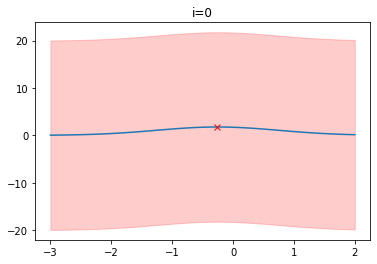

Latter term (100, 100) but should be: [100,100]
Latter term (100, 100) but should be: [100,100]
Latter term (100, 100) but should be: [100,100]
Latter term (100, 100) but should be: [100,100]
Latter term (100, 100) but should be: [100,100]


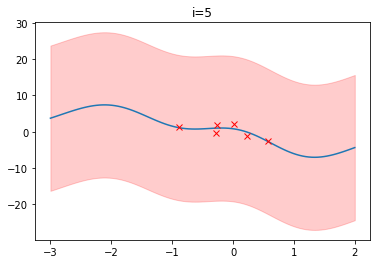

Latter term (100, 100) but should be: [100,100]
Latter term (100, 100) but should be: [100,100]
Latter term (100, 100) but should be: [100,100]
Latter term (100, 100) but should be: [100,100]
Latter term (100, 100) but should be: [100,100]


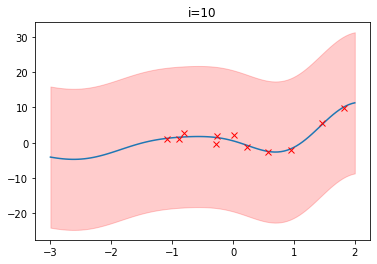

Latter term (100, 100) but should be: [100,100]
Latter term (100, 100) but should be: [100,100]
Latter term (100, 100) but should be: [100,100]
Latter term (100, 100) but should be: [100,100]
Latter term (100, 100) but should be: [100,100]


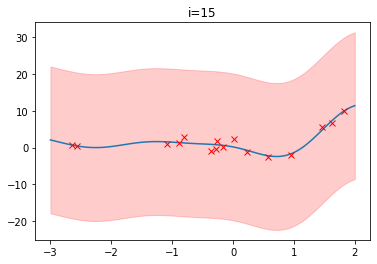

Latter term (100, 100) but should be: [100,100]
Latter term (100, 100) but should be: [100,100]
Latter term (100, 100) but should be: [100,100]
Latter term (100, 100) but should be: [100,100]
Latter term (100, 100) but should be: [100,100]


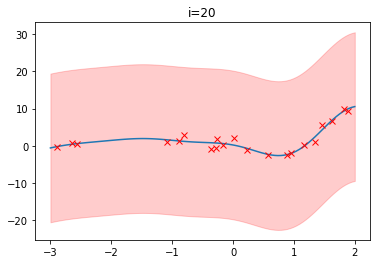

Latter term (100, 100) but should be: [100,100]
Latter term (100, 100) but should be: [100,100]
Latter term (100, 100) but should be: [100,100]
Latter term (100, 100) but should be: [100,100]
Latter term (100, 100) but should be: [100,100]


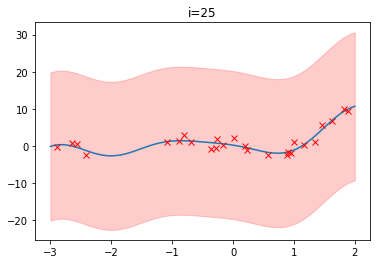

Latter term (100, 100) but should be: [100,100]
Latter term (100, 100) but should be: [100,100]
Latter term (100, 100) but should be: [100,100]
Latter term (100, 100) but should be: [100,100]


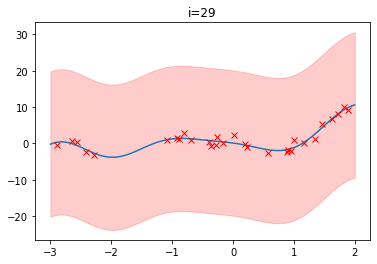

Latter term (100, 100) but should be: [100,100]


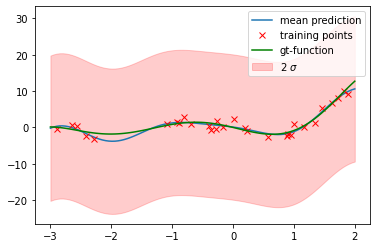

In [87]:
sigma_kern = 1              # standard deviation of function noise (given)
inv_lamb = 1000             # inverse lambda value -> equivalent to lambda = 1e-3
gp_fig = plt.figure()

# Let's go through the training data and add on training point to the system in each iteration and let's plot
# everything dynamically
x_dyn_train = []
y_dyn_train = []
for i in range(x_train.shape[0]):
    x_dyn_train.append(x_train[i])
    y_dyn_train.append(y_train[i])
    mean, var = predictive_distr_gp(x_plot, np.array(y_dyn_train), np.array(x_dyn_train), sigma_kern, inv_lamb)
    # print(f"Shapes: {mean.shape} and {var.shape}")
    if i % 5 == 0:
        plt.figure(gp_fig.number)
        gp_fig.clf()
        plt.plot(x_plot[:, 0], mean[:, 0])
        plt.fill_between(x_plot[:, 0], mean[:, 0] -2*np.sqrt(var), mean[:,0]+2*np.sqrt(var), 
                         alpha=0.2, edgecolor='r', facecolor='r')
        plt.plot(np.array(x_dyn_train), np.array(y_dyn_train), 'rx')
        plt.title('i='+ str(i))
        plt.pause(0.5)
    elif i == x_train.shape[0]-1:
        plt.figure(gp_fig.number)
        gp_fig.clf()
        plt.plot(x_plot[:, 0], mean[:, 0])
        plt.fill_between(x_plot[:, 0], mean[:, 0] -2*np.sqrt(var), mean[:,0]+2*np.sqrt(var), 
                         alpha=0.2, edgecolor='r', facecolor='r')
        plt.plot(np.array(x_dyn_train), np.array(y_dyn_train), 'rx')
        plt.title('i='+ str(i))
        plt.pause(0.5)

# now let's see the function approximation with all training data and compare to the ground truth function
mean, var = predictive_distr_gp(x_plot, y_train, x_train,sigma_kern, inv_lamb)

plt.figure()
plt.plot(x_plot[:, 0], mean[:, 0])
plt.fill_between(x_plot[:, 0], mean[:, 0] -2*np.sqrt(var), mean[:,0]+2*np.sqrt(var), 
                 alpha=0.2, edgecolor='r', facecolor='r')
plt.plot(np.array(x_train), np.array(y_train), 'rx')
plt.plot(x_plot, y_plot, 'g')

plt.legend(['mean prediction',  'training points', 'gt-function', '2 $\sigma$',])

